# 二维卷积实验

## 0 数据加载

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import os
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(114514)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(114514)

DATA_ROOT = (
    "D:/files/works/DeepLearning/experiment3/data/car-classificationproject-vision"
)


# --- 1. 自定义测试集 Dataset ---
class CustomTestDataset(Dataset):
    """用于加载无标签测试集（仅返回图像和文件名）"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f
            for f in os.listdir(root_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        try:
            self.image_files.sort(
                key=lambda x: int(x.split(".")[0].replace("image", ""))
            )
        except ValueError:
            self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name


# --- 2. 改进的数据加载函数（解决验证集Transform问题）---
def setup_data_loaders(
    data_root: str,
    image_size: int = 227,
    batch_size: int = 45,
    split_ratio: float = 0.8,
    num_workers: int = 4,
) -> tuple[DataLoader, DataLoader, DataLoader, int]:
    """
    设置和返回训练集、验证集和测试集的数据加载器，以及类别数量。

    关键改进：
    - 训练集使用数据增强
    - 验证集使用标准预处理（无增强）
    - 通过创建两个ImageFolder并用Subset索引的方式实现
    """

    # 2.1 配置路径
    TRAIN_DIR = os.path.join(data_root, "Train/Train")
    TEST_DIR = os.path.join(data_root, "Test/Test/Test1")

    # ImageNet 标准均值和标准差
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # 2.2 定义数据预处理
    # 训练集：包含数据增强
    train_transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),  # 添加轻微旋转
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ]
    )

    # 验证集和测试集：仅标准预处理，无数据增强
    eval_transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ]
    )

    # 2.3 关键改进：创建两个ImageFolder实例
    # 一个用于训练（带增强），一个用于验证（不带增强）
    full_train_dataset = datasets.ImageFolder(
        root=TRAIN_DIR, transform=train_transforms
    )
    full_eval_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=eval_transforms)

    num_classes = len(full_train_dataset.classes)
    total_size = len(full_train_dataset)

    # 2.4 计算划分大小
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    # 2.5 生成索引列表（确保训练集和验证集不重叠）
    import random

    random.seed(42)  # 设置随机种子保证可复现
    indices = list(range(total_size))
    random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # 2.6 使用Subset创建数据集
    # 训练集使用带增强的transforms
    train_dataset = Subset(full_train_dataset, train_indices)
    # 验证集使用不带增强的transforms
    val_dataset = Subset(full_eval_dataset, val_indices)

    # 2.7 创建 DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # 2.8 加载测试集（无标签）
    test_dataset = CustomTestDataset(root_dir=TEST_DIR, transform=eval_transforms)

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # 打印信息
    print(f"✓ 检测到的类别数量: {num_classes}")
    print(f"✓ 训练集大小: {len(train_dataset)} (使用数据增强)")
    print(f"✓ 验证集大小: {len(val_dataset)} (不使用数据增强)")
    print(f"✓ 测试集大小: {len(test_dataset)}")
    print(f"✓ 数据加载完成，Batch Size: {batch_size}")

    return train_loader, val_loader, test_loader, num_classes

## 1 手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [2]:
class Model(nn.Module):
    def __init__(
        self,
        chns_in: int,
        chns_out: int,
        ker_size: int,
        nums_classes: int,
        device: torch.device,
    ) -> None:
        super().__init__()
        self.chns_in = chns_in
        self.chns_out = chns_out
        self.ker_size = ker_size
        self.nums_classes = nums_classes
        self.conv = nn.Sequential(
            Model.MyConv2D(self.chns_in, self.chns_out, self.ker_size),
            nn.BatchNorm2d(self.chns_out),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 形状变为 (N, chns_out, 1, 1)
        self.fc = nn.Sequential(nn.Linear(self.chns_out, self.nums_classes))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.avgpool(X)  # 形状变为 (N, chns_out, 1, 1)
        X = X.flatten(1)  # 形状变为 (N, chns_out)
        X = self.fc(X)
        return X

    class MyConv2D(nn.Module):
        def __init__(self, chns_in: int, chns_out: int, ker_size: int) -> None:
            super().__init__()
            self.weight = nn.Parameter(
                torch.randn(size=(chns_out, chns_in, ker_size, ker_size))
            )
            self.bias = nn.Parameter(torch.randn(size=(1, chns_out, 1, 1)))

        def forward(self, X: torch.Tensor, padding=0, stride=1) -> torch.Tensor:
            return (
                Model.MyConv2D._corr2d_NCHW(X, self.weight, padding, stride)
                + self.bias  # (n,chns_out,(XH-KH+2P)/S,(XW-KW+2P)/S)
            )

        @staticmethod
        def _corr2d_HW(
            X_HW: torch.Tensor, K_HW: torch.Tensor, padding: int = 0, stride: int = 1
        ) -> torch.Tensor:
            # 扩展
            if padding > 0:
                X_HW = F.pad(X_HW, (padding, padding, padding, padding), "constant", 0)
            # 计算输出形状
            height_X, width_X = X_HW.shape
            height_K, width_K = K_HW.shape
            H_out = (height_X - height_K) // stride + 1
            W_out = (width_X - width_K) // stride + 1
            Y = torch.zeros((H_out, W_out), device=X_HW.device)
            # 滑动窗口循环
            for i in range(H_out):
                for j in range(W_out):
                    Y[i, j] = (
                        X_HW[
                            i * stride : i * stride + height_K,
                            j * stride : j * stride + width_K,
                        ]
                        * K_HW
                    ).sum()
            return Y

        @staticmethod
        def _corr2d_CHW(
            X_CHW: torch.Tensor, K_OIHW: torch.Tensor, padding: int = 0, stride: int = 1
        ) -> torch.Tensor:
            # 为循环做准备，定好循环次数
            chns_in = X_CHW.shape[0]
            chns_out = K_OIHW.shape[0]
            Y_list = []  # 用于保存每个输出通道的卷积结果
            for chn_out in range(chns_out):
                K_out = K_OIHW[chn_out]
                result = 0  # 用于保存当前输出通道的卷积结果(所有输入通道的卷积结果相加)
                for chn_in in range(chns_in):
                    Y = Model.MyConv2D._corr2d_HW(
                        X_CHW[chn_in], K_out[chn_in], padding, stride
                    )
                    result += Y
                Y_list.append(result)
            return torch.stack(Y_list, dim=0)

        @staticmethod
        def _corr2d_NCHW(
            X_NCHW: torch.Tensor, K_OIHW: torch.Tensor, padding: int, stride: int
        ) -> torch.Tensor:
            nums = X_NCHW.shape[0]
            Y_list = []
            for n in range(nums):
                Y = Model.MyConv2D._corr2d_CHW(X_NCHW[n], K_OIHW, padding, stride)
                Y_list.append(Y)
            return torch.stack(Y_list, dim=0)

In [3]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

    def __call__(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.calc(y_pred, y_true)

In [4]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = optim.AdamW(model.parameters(), lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [ ]:
def evaluation(model: Model, loss: Loss, data_loader: DataLoader, device: torch.device):
    model.eval()
    with torch.no_grad():
        total_nums = 0
        data_loss_value, data_acc_value = 0, 0
        tqdm_batch = tqdm(data_loader, desc="Eval", leave=False, position=1)
        for features, labels in tqdm_batch:
            features, labels = features.to(device), labels.to(device)
            predict = model(features)
            loss_value = loss(predict, labels)

            total_nums += len(labels)
            data_loss_value += loss_value.item() * len(labels)
            data_acc_value += (predict.argmax(dim=1) == labels).sum().item()
            tqdm_batch.set_postfix_str(f"Current Batch Loss={loss_value.item():.4f}")
        data_loss_value /= total_nums
        data_acc_value /= total_nums
    return data_loss_value, data_acc_value

In [ ]:
def train(
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nnum_epoches: int,
    device: torch.device,
    accumulation_steps: int,
):
    print(f"batch积累倍率:{accumulation_steps}")
    train_loss_list, train_acc_list = [], []
    valid_loss_list, valid_acc_list = [], []
    tqdm_epoch = tqdm(range(nnum_epoches), desc="Epochs", leave=True, position=0)
    for epoch in tqdm_epoch:
        model.train()
        total_nums = 0
        train_loss, train_acc = 0.0, 0.0
        # 在循环开始前清零
        optimizer.zero_grad()
        tqdm_batch = tqdm(train_loader, desc=f"Train", leave=False, position=1)
        for i, (images, labels) in enumerate(tqdm_batch):
            images, labels = images.to(device), labels.to(device)
            # 前向计算
            predict = model(images)
            raw_loss = loss(predict, labels)  # 保存原始 loss 用于统计
            # 1. 梯度缩放与反向传播
            loss_accumulated = raw_loss / accumulation_steps
            loss_accumulated.backward()
            # 2. 达到步数更新梯度
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            # 3. 统计数据使用原始 loss (raw_loss)
            total_nums += len(labels)
            train_loss += raw_loss.item() * len(labels)  # 这里用 raw_loss 保证统计准确
            train_acc += (predict.argmax(dim=1) == labels).sum().item()
            # 更新当前batch信息
            tqdm_batch.set_postfix_str(f"Current Batch Loss={raw_loss.item():.4f}")
        # 4. 处理 Epoch 末尾未达步数的残余梯度
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        # 计算平均值并输出返回
        train_loss /= total_nums
        train_acc /= total_nums
        valid_loss, valid_acc = evaluation(model, loss, valid_loader, device)
        tqdm_epoch.set_postfix_str(
            f"epoch{epoch+1} Info:\
            TrainLoss={train_loss:.4f} ValidLoss={valid_loss:.4f} \
            TrainAcc={train_acc:.4f} ValidAcc={valid_acc:.4f}",
        )
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
train_loader, val_loader, test_loader, num_classes = setup_data_loaders(
    data_root=DATA_ROOT,
    image_size=224,
    batch_size=2,
    split_ratio=0.8,
    num_workers=4,
)
model = Model(
    chns_in=3,
    chns_out=4,
    ker_size=3,
    nums_classes=45,
    device=device,
).to(device)
loss = Loss()
optimizer = Optimizer(model=model, lr=0.003)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=val_loader,
    nnum_epoches=2,
    device=device,
    accumulation_steps=1,
)

✓ 检测到的类别数量: 45
✓ 训练集大小: 3240 (使用数据增强)
✓ 验证集大小: 810 (不使用数据增强)
✓ 测试集大小: 450
✓ 数据加载完成，Batch Size: 2


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batchs:   0%|          | 0/1620 [00:15<?, ?it/s]

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list, label="train_loss")
axes[0].plot(valid_loss_list, label="valid_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[1].plot(train_acc_list, label="train_acc")
axes[1].plot(valid_acc_list, label="valid_acc")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()

## 2 使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [2]:
class Model(nn.Module):
    def __init__(
        self,
        chns_in: int,
        chns_base: int,
        feats_base: int,
        nums_classes: int,
        dropout_rate: float,
        ker_size: int,
        padding: int = 0,
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.chns_in = chns_in
        self.chns_base = chns_base
        self.feats_base = feats_base
        self.nums_classes = nums_classes
        self.dropout_rate = dropout_rate
        self.ker_size = ker_size
        self.padding = padding
        self.stride = stride

        self.conv = nn.Sequential(
            # cov1
            nn.Conv2d(
                chns_in,
                chns_base * 1,
                kernel_size=ker_size,
                padding=self.padding,
                stride=self.stride,
            ),
            nn.BatchNorm2d(chns_base * 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # cov2
            nn.Conv2d(
                chns_base * 1,
                chns_base * 2,
                kernel_size=ker_size,
                padding=self.padding,
                stride=self.stride,
            ),
            nn.BatchNorm2d(chns_base * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # conv3
            nn.Conv2d(
                chns_base * 2,
                chns_base * 4,
                kernel_size=ker_size,
                padding=self.padding,
                stride=self.stride,
            ),
            nn.BatchNorm2d(chns_base * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # conv4
            nn.Conv2d(
                chns_base * 4,
                chns_base * 8,
                kernel_size=ker_size,
                padding=self.padding,
                stride=self.stride,
            ),
            nn.BatchNorm2d(chns_base * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Sequential(
            # fc1
            nn.Linear(self.chns_base * 8, self.feats_base),
            # nn.BatchNorm1d(self.feats_base),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_rate),
            # # fc2
            # nn.Linear(self.feats_base, self.feats_base),
            # nn.BatchNorm1d(self.feats_base),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=self.dropout_rate),
            # fc3
            nn.Linear(self.feats_base, self.nums_classes),
        )
        # 权重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        """Kaiming初始化"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.pool(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)
        return X

In [3]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

    def __call__(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.calc(y_pred, y_true)

In [4]:
class Optimizer:
    def __init__(
        self, model: Model, lr: float = 0.01, weight_decay: float = 0.01
    ) -> None:
        self.optimizer = optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [5]:
def evaluation(model: Model, loss: Loss, data_loader: DataLoader, device: torch.device):
    model.eval()
    with torch.no_grad():
        total_nums = 0
        data_loss_value, data_acc_value = 0, 0
        tqdm_batch = tqdm(data_loader, desc="Eval", leave=False, position=1)
        for features, labels in tqdm_batch:
            features, labels = features.to(device), labels.to(device)
            predict = model(features)
            loss_value = loss(predict, labels)

            total_nums += len(labels)
            data_loss_value += loss_value.item() * len(labels)
            data_acc_value += (predict.argmax(dim=1) == labels).sum().item()
            tqdm_batch.set_postfix_str(f"Current Batch Loss={loss_value.item():.4f}")
        data_loss_value /= total_nums
        data_acc_value /= total_nums
    return data_loss_value, data_acc_value

In [6]:
def train(
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nnum_epoches: int,
    device: torch.device,
    accumulation_steps: int,
):
    print(f"batch积累倍率:{accumulation_steps}")
    train_loss_list, train_acc_list = [], []
    valid_loss_list, valid_acc_list = [], []
    tqdm_epoch = tqdm(range(nnum_epoches), desc="Epochs", leave=True, position=0)
    for epoch in tqdm_epoch:
        model.train()
        total_nums = 0
        train_loss, train_acc = 0.0, 0.0
        # 在循环开始前清零
        optimizer.zero_grad()
        tqdm_batch = tqdm(train_loader, desc=f"Train", leave=False, position=1)
        for i, (images, labels) in enumerate(tqdm_batch):
            images, labels = images.to(device), labels.to(device)
            # 前向计算
            predict = model(images)
            raw_loss = loss(predict, labels)  # 保存原始 loss 用于统计
            # 1. 梯度缩放与反向传播
            loss_accumulated = raw_loss / accumulation_steps
            loss_accumulated.backward()
            # 2. 达到步数更新梯度
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            # 3. 统计数据使用原始 loss (raw_loss)
            total_nums += len(labels)
            train_loss += raw_loss.item() * len(labels)  # 这里用 raw_loss 保证统计准确
            train_acc += (predict.argmax(dim=1) == labels).sum().item()
            # 更新当前batch信息
            tqdm_batch.set_postfix_str(f"Current Batch Loss={raw_loss.item():.4f}")
        # 4. 处理 Epoch 末尾未达步数的残余梯度
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        # 计算平均值并输出返回
        train_loss /= total_nums
        train_acc /= total_nums
        valid_loss, valid_acc = evaluation(model, loss, valid_loader, device)
        tqdm_epoch.set_postfix_str(
            f"epoch{epoch+1} Info:\
            TrainLoss={train_loss:.4f} ValidLoss={valid_loss:.4f} \
            TrainAcc={train_acc:.4f} ValidAcc={valid_acc:.4f}",
        )
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
train_loader, val_loader, test_loader, num_classes = setup_data_loaders(
    data_root=DATA_ROOT,
    image_size=224,
    batch_size=32,
    split_ratio=0.8,
    num_workers=4,
)
model = Model(
    chns_in=3,
    chns_base=64,
    feats_base=1024,
    dropout_rate=0.5,
    ker_size=3,
    nums_classes=num_classes,
    padding=1,
    stride=1,
).to(device)
loss = Loss()
optimizer = Optimizer(model=model, lr=1e-3, weight_decay=1e-4)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=val_loader,
    nnum_epoches=32,
    device=device,
    accumulation_steps=1,
)

✓ 检测到的类别数量: 45
✓ 训练集大小: 3240 (使用数据增强)
✓ 验证集大小: 810 (不使用数据增强)
✓ 测试集大小: 450
✓ 数据加载完成，Batch Size: 32
batch积累倍率:1


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/102 [00:16<?, ?it/s]

Eval:   0%|          | 0/26 [00:14<?, ?it/s]

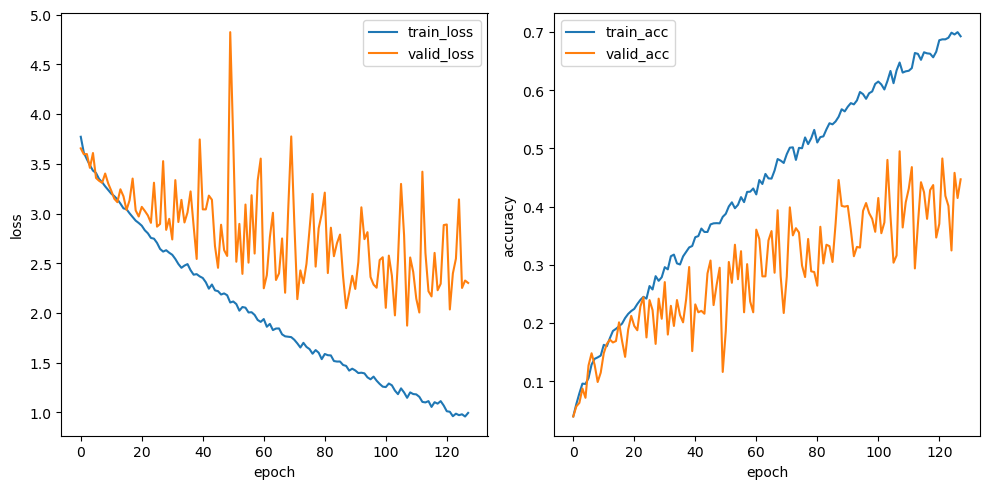

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list, label="train_loss")
axes[0].plot(valid_loss_list, label="valid_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[1].plot(train_acc_list, label="train_acc")
axes[1].plot(valid_acc_list, label="valid_acc")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()

## 3 不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析

In [ ]:
train_loader, val_loader, test_loader, num_classes = setup_data_loaders(
    data_root=DATA_ROOT,
    image_size=224,
    batch_size=32,
    split_ratio=0.8,
    num_workers=4,
)


def get_defaultModel():
    return Model(
        chns_in=3,
        chns_base=64,
        feats_base=1024,
        dropout_rate=0.5,
        ker_size=3,
        nums_classes=num_classes,
        padding=1,
        stride=1,
    ).to(device)


loss = Loss()
optimizer = Optimizer(model=model, lr=1e-3, weight_decay=1e-4)
# train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(
#     model=model,
#     loss=loss,
#     optimizer=optimizer,
#     train_loader=train_loader,
#     valid_loader=val_loader,
#     nnum_epoches=32,
#     device=device,
#     accumulation_steps=8,
# )

# 1: 对比不同的lr
# 原先的是lr=1e-3，此处不重复跑了
model_lr1 = get_defaultModel()
optimizer_lr1 = Optimizer(model=model_lr1, lr=1e-2, weight_decay=1e-4)
model_lr2 = get_defaultModel()
optimizer_lr2 = Optimizer(model=model_lr2, lr=1e-4, weight_decay=1e-4)
train_loss_list_lr1, train_acc_list_lr1, valid_loss_list_lr1, valid_acc_list_lr1 = (
    train(
        model=model_lr1,
        loss=loss,
        optimizer=optimizer_lr1,
        train_loader=train_loader,
        valid_loader=val_loader,
        nnum_epoches=32,
        device=device,
        accumulation_steps=1,
    )
)
train_loss_list_lr2, train_acc_list_lr2, valid_loss_list_lr2, valid_acc_list_lr2 = (
    train(
        model=model_lr2,
        loss=loss,
        optimizer=optimizer_lr2,
        train_loader=train_loader,
        valid_loader=val_loader,
        nnum_epoches=32,
        device=device,
        accumulation_steps=1,
    )
)
# 2: 对比不同的kernel_size
# 此前的kernel_size为3，现在尝试kernel_size为5
model_kr1 = Model(
    chns_in=3,
    chns_base=64,
    feats_base=1024,
    dropout_rate=0.5,
    ker_size=5,
    nums_classes=num_classes,
    padding=2,
    stride=1,
).to(device)
optimizer_kr1 = Optimizer(model=model_kr1, lr=1e-4, weight_decay=1e-4)
train_loss_list_kr1, train_acc_list_kr1, valid_loss_list_kr1, valid_acc_list_kr1 = (
    train(
        model=model_kr1,
        loss=loss,
        optimizer=optimizer_kr1,
        train_loader=train_loader,
        valid_loader=val_loader,
        nnum_epoches=32,
        device=device,
        accumulation_steps=1,
    )
)

NameError: name 'train_loss_list' is not defined

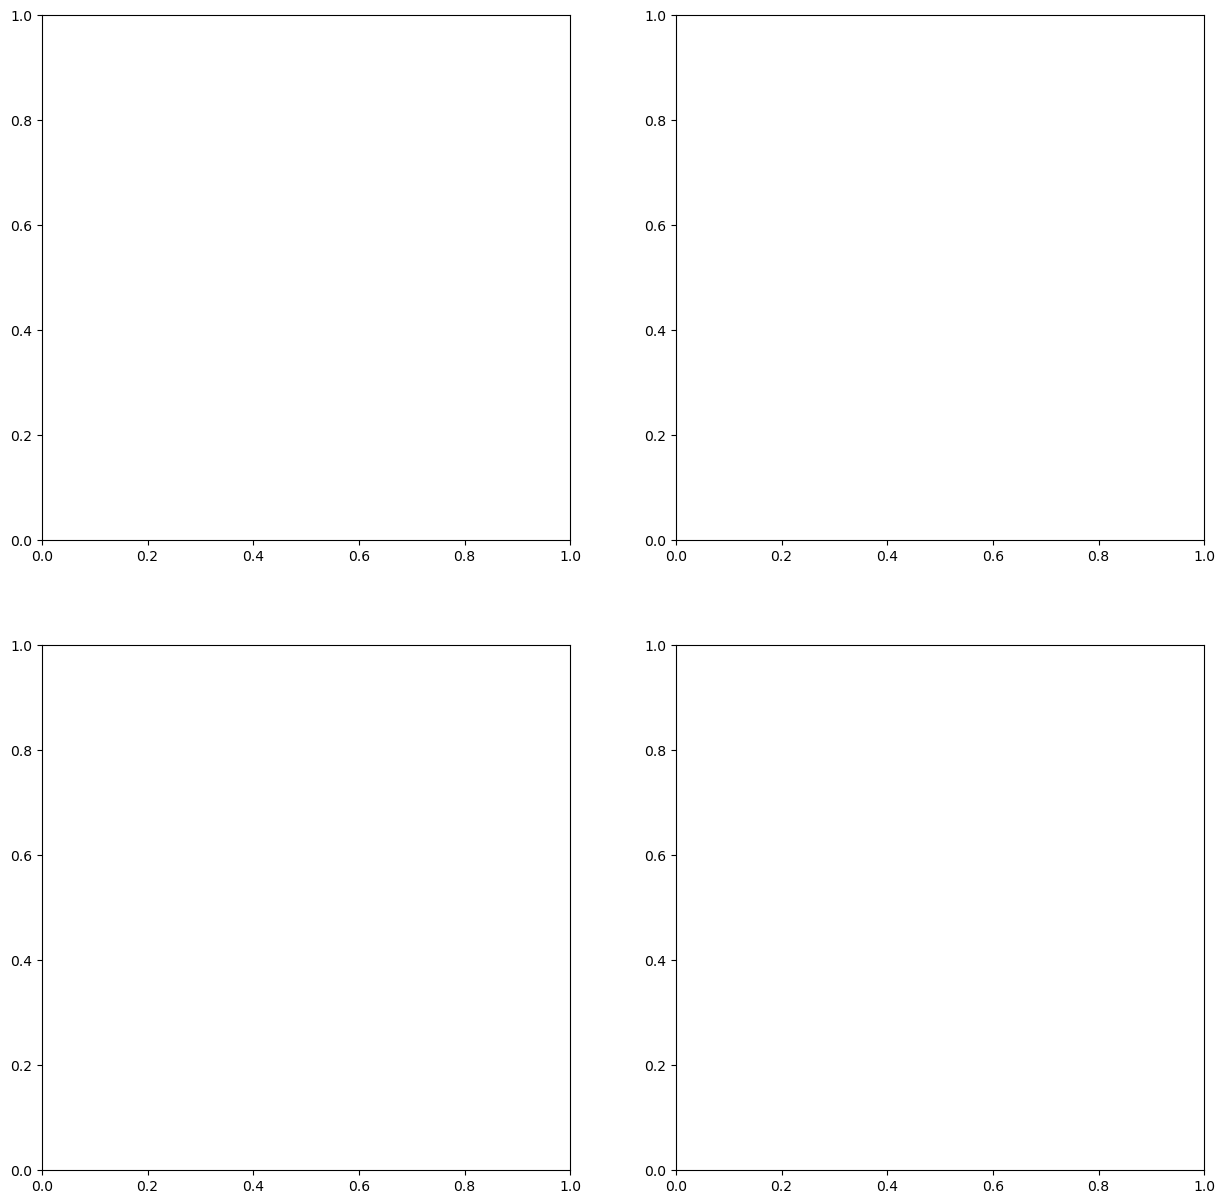

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize=(15, 12)) # 12的高度通常比例更协调

# --- 0, 0: Loss vs Learning Rate ---
axes[0, 0].plot(train_loss_list, color="tab:blue", linestyle="-", label="train-lr=1e-3")
axes[0, 0].plot(valid_loss_list, color="tab:blue", linestyle="--", label="valid-lr=1e-3")
axes[0, 0].plot(train_loss_list_lr1, color="tab:orange", linestyle="-", label="train-lr=1e-2")
axes[0, 0].plot(valid_loss_list_lr1, color="tab:orange", linestyle="--", label="valid-lr=1e-2")
axes[0, 0].plot(train_loss_list_lr2, color="tab:green", linestyle="-", label="train-lr=1e-4")
axes[0, 0].plot(valid_loss_list_lr2, color="tab:green", linestyle="--", label="valid-lr=1e-4")
axes[0, 0].set_title("Training & Validation Loss (Different LR)")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend(ncol=2, fontsize='small') # 双列图例防止遮挡
axes[0, 0].grid(True, linestyle=':', alpha=0.6)

# --- 0, 1: Accuracy vs Learning Rate ---
axes[0, 1].plot(train_acc_list, color="tab:blue", linestyle="-", label="train-lr=1e-3")
axes[0, 1].plot(valid_acc_list, color="tab:blue", linestyle="--", label="valid-lr=1e-3")
axes[0, 1].plot(train_acc_list_lr1, color="tab:orange", linestyle="-", label="train-lr=1e-2")
axes[0, 1].plot(valid_acc_list_lr1, color="tab:orange", linestyle="--", label="valid-lr=1e-2")
axes[0, 1].plot(train_acc_list_lr2, color="tab:green", linestyle="-", label="train-lr=1e-4")
axes[0, 1].plot(valid_acc_list_lr2, color="tab:green", linestyle="--", label="valid-lr=1e-4")
axes[0, 1].set_title("Training & Validation Accuracy (Different LR)")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].legend(ncol=2, fontsize='small')
axes[0, 1].grid(True, linestyle=':', alpha=0.6)

# --- 1, 0: Loss vs Kernel Size ---
axes[1, 0].plot(train_loss_list, color="tab:blue", linestyle="-", label="train-ks=3")
axes[1, 0].plot(valid_loss_list, color="tab:blue", linestyle="--", label="valid-ks=3")
axes[1, 0].plot(train_loss_list_kr1, color="tab:orange", linestyle="-", label="train-ks=5")
axes[1, 0].plot(valid_loss_list_kr1, color="tab:orange", linestyle="--", label="valid-ks=5")
axes[1, 0].set_title("Training & Validation Loss (Different Kernel Size)")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle=':', alpha=0.6)

# --- 1, 1: Accuracy vs Kernel Size ---
axes[1, 1].plot(train_acc_list, color="tab:blue", linestyle="-", label="train-ks=3")
axes[1, 1].plot(valid_acc_list, color="tab:blue", linestyle="--", label="valid-ks=3")
axes[1, 1].plot(train_acc_list_kr1, color="tab:orange", linestyle="-", label="train-ks=5")
axes[1, 1].plot(valid_acc_list_kr1, color="tab:orange", linestyle="--", label="valid-ks=5")
axes[1, 1].set_title("Training & Validation Accuracy (Different Kernel Size)")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


## 4 使用PyTorch实现经典模型AlexNet并在至少一个数据集进行试验分析 （无GPU环境则至少实现模型）

In [ ]:
class Model(nn.Module):
    def __init__(
        self,
        chns_in: int,
        chns_mid: list[int],
        ker_size: list[int],
        padding: list[int],
        stride: list[int],
        poolKer_size: list[int],
        poolStride: list[int],
        feats_mid: list[int],
        feats_out: int,
        dropout_rate: list[float],
    ) -> None:
        super().__init__()
        self.chns_in = chns_in
        self.chns_mid = chns_mid
        self.ker_size = ker_size
        self.padding = padding
        self.stride = stride
        self.poolKer_size = poolKer_size
        self.poolStride = poolStride
        self.feats_mid = feats_mid
        self.feats_out = feats_out
        self.dropout_rate = dropout_rate

        self.conv = nn.Sequential(
            # cov1
            nn.Conv2d(
                in_channels=self.chns_in,
                out_channels=self.chns_mid[0],
                kernel_size=self.ker_size[0],
                padding=self.padding[0],
                stride=self.stride[0],
            ),
            # nn.BatchNorm2d(chns_mid[0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(self.poolKer_size[0], self.poolStride[0]),
            # cov2
            nn.Conv2d(
                in_channels=self.chns_mid[0],
                out_channels=self.chns_mid[1],
                kernel_size=self.ker_size[1],
                padding=self.padding[1],
                stride=self.stride[1],
            ),
            # nn.BatchNorm2d(chns_mid[1]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(self.poolKer_size[1], self.poolStride[1]),
            # cov3
            nn.Conv2d(
                in_channels=self.chns_mid[1],
                out_channels=self.chns_mid[2],
                kernel_size=self.ker_size[2],
                padding=self.padding[2],
                stride=self.stride[2],
            ),
            # nn.BatchNorm2d(chns_mid[2]),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(self.poolKer_size[2], self.poolStride[2]),
            # cov4
            nn.Conv2d(
                in_channels=self.chns_mid[2],
                out_channels=self.chns_mid[3],
                kernel_size=self.ker_size[3],
                padding=self.padding[3],
                stride=self.stride[3],
            ),
            # nn.BatchNorm2d(chns_mid[3]),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(self.poolKer_size[3], self.poolStride[3]),
        )
        self.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Sequential(
            # fc1
            nn.Linear(self.chns_mid[3], self.feats_mid[0]),
            # nn.BatchNorm1d(self.feats_mid[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_rate[0]),
            # fc2
            nn.Linear(self.feats_mid[0], self.feats_mid[1]),
            # nn.BatchNorm1d(self.feats_mid[1]),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_rate[1]),
            #fc3
            nn.Linear(self.feats_mid[1], self.feats_out),
        )
        # 权重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        """Kaiming初始化"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.pool(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)
        return X

In [ ]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

    def __call__(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.calc(y_pred, y_true)

In [ ]:
class Optimizer:
    def __init__(
        self, model: Model, lr: float = 0.01, weight_decay: float = 0.01
    ) -> None:
        self.optimizer = optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [ ]:
def evaluation(model: Model, loss: Loss, data_loader: DataLoader, device: torch.device):
    model.eval()
    with torch.no_grad():
        total_nums = 0
        data_loss_value, data_acc_value = 0, 0
        tqdm_batch = tqdm(data_loader, desc="Eval", leave=False, position=1)
        for features, labels in tqdm_batch:
            features, labels = features.to(device), labels.to(device)
            predict = model(features)
            loss_value = loss(predict, labels)

            total_nums += len(labels)
            data_loss_value += loss_value.item() * len(labels)
            data_acc_value += (predict.argmax(dim=1) == labels).sum().item()
            tqdm_batch.set_postfix_str(f"Current Batch Loss={loss_value.item():.4f}")
        data_loss_value /= total_nums
        data_acc_value /= total_nums
    return data_loss_value, data_acc_value

In [ ]:
def train(
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nnum_epoches: int,
    device: torch.device,
    accumulation_steps: int,
):
    print(f"batch积累倍率:{accumulation_steps}")
    train_loss_list, train_acc_list = [], []
    valid_loss_list, valid_acc_list = [], []
    tqdm_epoch = tqdm(range(nnum_epoches), desc="Epochs", leave=True, position=0)
    for epoch in tqdm_epoch:
        model.train()
        total_nums = 0
        train_loss, train_acc = 0.0, 0.0
        # 在循环开始前清零
        optimizer.zero_grad()
        tqdm_batch = tqdm(train_loader, desc=f"Train", leave=False, position=1)
        for i, (images, labels) in enumerate(tqdm_batch):
            images, labels = images.to(device), labels.to(device)
            # 前向计算
            predict = model(images)
            raw_loss = loss(predict, labels)  # 保存原始 loss 用于统计
            # 1. 梯度缩放与反向传播
            loss_accumulated = raw_loss / accumulation_steps
            loss_accumulated.backward()
            # 2. 达到步数更新梯度
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            # 3. 统计数据使用原始 loss (raw_loss)
            total_nums += len(labels)
            train_loss += raw_loss.item() * len(labels)  # 这里用 raw_loss 保证统计准确
            train_acc += (predict.argmax(dim=1) == labels).sum().item()
            # 更新当前batch信息
            tqdm_batch.set_postfix_str(f"Current Batch Loss={raw_loss.item():.4f}")
        # 4. 处理 Epoch 末尾未达步数的残余梯度
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        # 计算平均值并输出返回
        train_loss /= total_nums
        train_acc /= total_nums
        valid_loss, valid_acc = evaluation(model, loss, valid_loader, device)
        tqdm_epoch.set_postfix_str(
            f"epoch{epoch+1} Info:\
            TrainLoss={train_loss:.4f} ValidLoss={valid_loss:.4f} \
            TrainAcc={train_acc:.4f} ValidAcc={valid_acc:.4f}",
        )
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
train_loader, val_loader, test_loader, num_classes = setup_data_loaders(
    data_root=DATA_ROOT,
    image_size=224,
    batch_size=32,
    split_ratio=0.8,
    num_workers=4,
)
model = Model(
    chns_in=3,
    chns_mid=[96, 256, 384, 384],
    ker_size=[11, 5, 3, 3],
    padding=[2, 2, 1, 1],
    stride=[4, 1, 1, 1],
    poolKer_size=[3, 3],
    poolStride=[2, 2],
    feats_mid=[4096, 4096],
    feats_out=num_classes,
    dropout_rate=[0.4, 0.4],
).to(device)
loss = Loss()
optimizer = Optimizer(model=model, lr=1e-3, weight_decay=1e-4)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=val_loader,
    nnum_epoches=32,
    device=device,
    accumulation_steps=1,
)

✓ 检测到的类别数量: 45
✓ 训练集大小: 3240 (使用数据增强)
✓ 验证集大小: 810 (不使用数据增强)
✓ 测试集大小: 450
✓ 数据加载完成，Batch Size: 32


Epochs:   0%|          | 0/128 [00:00<?, ?it/s]

Batchs:   0%|          | 0/102 [00:15<?, ?it/s]

Batchs:   0%|          | 0/102 [00:14<?, ?it/s]

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list, label="train_loss")
axes[0].plot(valid_loss_list, label="valid_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[1].plot(train_acc_list, label="train_acc")
axes[1].plot(valid_acc_list, label="valid_acc")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()

## 5 使用实验2中的前馈神经网络模型在本次给定数据集上进行实验，并将实验结果与卷积模型结果进行对比分析（选做）